## Data Loading and Organzination

In [1]:
from PIL import Image
import numpy as np
import glob

def build_dataset():
	org_dataset = []
    
	for i in range(1, 16):
		filelist = glob.glob('./yalefaces-1/yalefaces-1/subject'+str(i).zfill(2)+"*")
		for fname in filelist:
			img = np.array(Image.open(fname))
			img = img.reshape(img.shape[0]*img.shape[1])
			org_dataset.append(img)

	org_dataset = np.array(org_dataset)
    
	return org_dataset

org_dataset = build_dataset()
num_components = len(org_dataset)

In [2]:
len(org_dataset)

165

## Normalizing Dataset for Eigen Vector Calculation

In [3]:
def normalize(org_dataset):
	mean_vector = np.mean(org_dataset, axis=0)
	dataset = org_dataset - mean_vector

	return dataset, mean_vector

dataset, mean_vector = normalize(org_dataset)

## Eigen vectors and eigen values

In [4]:
from numpy import linalg as la

def calc_eig_val_vec(dataset):
	cov_mat = np.dot(dataset, dataset.T)
	eig_values, eigen_vectors = la.eig(cov_mat)
	eig_vectors = np.dot(dataset.T, eigen_vectors)
	for i in range(eig_vectors.shape[1]):
		eig_vectors[:, i] = eig_vectors[:, i]/la.norm(eig_vectors[:, i])
	return eig_values.astype(float), eig_vectors.astype(float)

eig_values, eig_vectors = calc_eig_val_vec(dataset)

C:\Users\Rubayyat Mahbub\Python3\Anaconda\lib\site-packages\ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


## Get 'k' eigen faces

In [5]:
def pca(eig_values, eig_vectors, k):
	k_eig_val = eig_values.argsort()[-k:][::-1]
	eigen_faces = []
    
	for i in k_eig_val:
		eigen_faces.append(eig_vectors[:, i])

	eigen_faces = np.array(eigen_faces)
    
	return eigen_faces

eigen_faces = pca(eig_values, eig_vectors, num_components)

## Reconstruct images

In [6]:
def reconstruct_images(eigen_faces, mean_vector):
	org_dim_eig_faces = []
    
	for i in range(eigen_faces.shape[0]):
		org_dim_eig_faces.append(eigen_faces[i].reshape(243, 320))

	org_dim_eig_faces = np.array(org_dim_eig_faces)
    
	return org_dim_eig_faces

org_dim_eig_faces = reconstruct_images(eigen_faces, mean_vector)

## Plotting the first k=15 eigen values

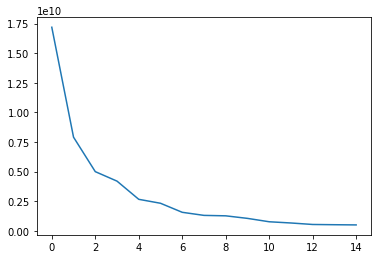

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(eig_values[:15])
plt.show()
plt.clf()

## Calculating number of eigen vectors required to capture 90% Information

In [9]:
from numpy import trapz

total_energy = trapz(eig_values, dx=1)
print("Total Energy:", total_energy)

k = 0
while True:
	k_energy = trapz(eig_values[:k], dx=1)
	print("Energy captured by", k, "components:", k_energy)
	if k_energy >= 0.9*total_energy:
		break
	k += 1

print("Number of components to capture 90% energy:", k)

Total Energy: 47692294393.4496
Energy captured by 0 components: 0.0
Energy captured by 1 components: 0.0
Energy captured by 2 components: 12546502748.638332
Energy captured by 3 components: 18994191128.318714
Energy captured by 4 components: 23585255322.409794
Energy captured by 5 components: 27007219964.474384
Energy captured by 6 components: 29494489963.101494
Energy captured by 7 components: 31433393030.786983
Energy captured by 8 components: 32860285500.243786
Energy captured by 9 components: 34138269643.550255
Energy captured by 10 components: 35289861300.601295
Energy captured by 11 components: 36190751526.758194
Energy captured by 12 components: 36896949888.951485
Energy captured by 13 components: 37488597770.03234
Energy captured by 14 components: 38007049459.611664
Energy captured by 15 components: 38506915677.27185
Energy captured by 16 components: 38977925246.351395
Energy captured by 17 components: 39409318580.5969
Energy captured by 18 components: 39800361415.63866
Energy 

## Plotting top 10 eigen faces

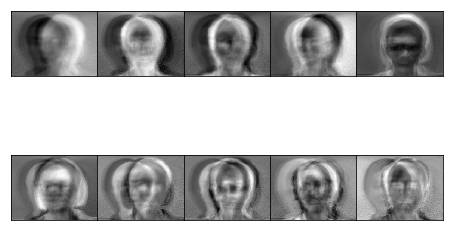

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 5, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   

i = 0
for g in gs:
    ax = plt.subplot(g)
    ax.imshow(org_dim_eig_faces[i], cmap = plt.get_cmap("gray"))
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1

plt.show()
plt.clf()

## Reconstructing random images with increasing eigen vectors using interactive plots

interactive(children=(IntSlider(value=24, description='num_steps', max=49), Output()), _dom_classes=('widget-i…

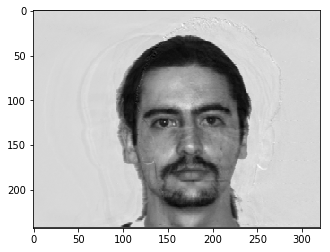

<Figure size 432x288 with 0 Axes>

In [10]:
import random

#k = np.concatenate(([1, 10, 20, 30, 40, 50, 100], [k]))
#k = np.array(([15,20,165]))
k=np.arange(0,50,1)

r1 = 0
r2 = 0
while r1==r2:
    r1 = random.randint(0, len(dataset)-1)
    r2 = random.randint(0, len(dataset)-1)

sample1 = dataset[r1]
sample2 = dataset[r2]

def project(org_dim_input, eigen_faces):
    return np.dot(org_dim_input, eigen_faces.T)

def reconstruct(projected_input, eigen_faces):
    reconstructed_input = []
    reconstructed_input = np.dot(projected_input, eigen_faces)
    mean_vector = np.mean(org_dataset, axis=0)
    return reconstructed_input + mean_vector

outputs = []
for j in k:
    projected_input1 = project(sample1, eigen_faces[:j])
    reconstructed_input1 = reconstruct(projected_input1, eigen_faces[:j])
    outputs.append(reconstructed_input1) 
    
    
from ipywidgets import interact, IntSlider

betas = np.array(outputs)

def plot_grad_desc(num_steps):
    plt.axes().set_aspect('equal')
    #plt.contour(xx, yy, zz, 10, colors = 'k')
    plt.imshow(outputs[num_steps].reshape(243, 320), cmap = plt.get_cmap("gray"))
    #plt.plot(betas[:num_steps+1,0],betas[:num_steps+1,1], marker = 'o', markersize=5)
    #plt.xlabel(r"$\beta_0$")
    plt.ylabel(r"$\beta_1$")

#interact(plot_grad_desc, num_steps=IntSlider(min=0,max=len(k)-1,step=1,value=15)); 
interact(plot_grad_desc, num_steps=(0,len(k)-1,1)); 


projected_input_all = project(sample1, eigen_faces[:165])
reconstructed_input_all = reconstruct(projected_input_all, eigen_faces[:165])
plt.imshow(reconstructed_input_all.reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.show()
plt.clf()


## Animation of reconstructing random image with increasing eigen vectors 

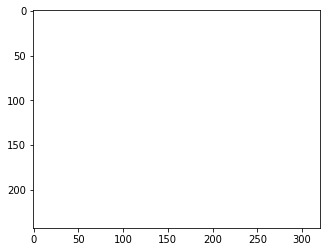

MovieWriter imagemagick unavailable.


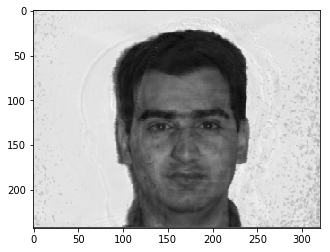

<Figure size 432x288 with 0 Axes>

In [143]:
#animation
import random

#k = np.concatenate(([1, 10, 20, 30, 40, 50, 100], [k]))
#k = np.array(([15,20,165]))
k=np.arange(0,150,1)

r1 = 0
r2 = 0
while r1==r2:
    r1 = random.randint(0, len(dataset)-1)
    r2 = random.randint(0, len(dataset)-1)

sample1 = dataset[r1]
sample2 = dataset[r2]

def project(org_dim_input, eigen_faces):
    return np.dot(org_dim_input, eigen_faces.T)

def reconstruct(projected_input, eigen_faces):
    reconstructed_input = []
    reconstructed_input = np.dot(projected_input, eigen_faces)
    mean_vector = np.mean(org_dataset, axis=0)
    return reconstructed_input + mean_vector

outputs = []
for j in k:
    projected_input1 = project(sample1, eigen_faces[:j])
    reconstructed_input1 = reconstruct(projected_input1, eigen_faces[:j])
    outputs.append(reconstructed_input1) 
    
    
from ipywidgets import interact, IntSlider
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#matplotlib.use("Agg")

# Set up formatting for the movie files

fig = plt.figure()

betas = np.array(outputs)
ims = []
for i in range(0,len(k)):
    im = plt.imshow(outputs[i].reshape(243, 320), cmap = plt.get_cmap("gray"), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()

# animation save: change file name
ani.save('animation.gif', writer='imagemagick', fps=50)


projected_input_all = project(sample1, eigen_faces[:165])
reconstructed_input_all = reconstruct(projected_input_all, eigen_faces[:165])
plt.imshow(reconstructed_input_all.reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.show()
plt.clf()

# Scatter Plot: 2D Projection using Plotly

In [48]:
## Setup Data
import random

k1=np.arange(0,165,1)

r1 = 0
r2 = 0
while r1==r2:
    r1 = random.randint(0, len(dataset)-1)
    r2 = random.randint(0, len(dataset)-1)

sample1 = dataset[r1]
sample2 = dataset[r2]

def project(org_dim_input, eigen_faces):
    return np.dot(org_dim_input, eigen_faces.T)

def reconstruct(projected_input, eigen_faces):
    reconstructed_input = []
    reconstructed_input = np.dot(projected_input, eigen_faces)
    mean_vector = np.mean(org_dataset, axis=0)
    return reconstructed_input + mean_vector

outputs1 = []
for j in k1:
    projected_input1 = project(dataX[j], eigen_faces[:2])
    outputs1.append(projected_input1 ) 
##labellilen(outputs1)    

In [54]:
#labeling whole data for scatter plot
label=[]
i = 0
while i!=15:
        for j in range(11):
                label.append(np.concatenate((org_dataset[i*11+j],[i+1])))
        i += 1
label = np.array(label)
dataX = label[:, :label.shape[1]-1]
labelX = (label[:, -1])

In [120]:
##Precess data for scatter plot: separate x,y,label
import plotly.plotly as py
data_x = []
data_y=[]
data_label_1=[]
data_label_2=[]

for name, col in zip(outputs1, labelX):
     data_x.append(name[0])
     data_y.append(name[1])
     data_label_1.append(str(col))
     data_label_2.append(col)

In [148]:
## scatterplot in 2d of all faces using plotly.
import plotly.graph_objs as go
import plotly
# use your user name and api key
plotly.tools.set_credentials_file(username='', api_key='')  
import plotly.plotly as py
data=[]
label=[]
#i = 0
for i in range(0,15):
    trace0 = go.Scatter(
        x = data_x[i*11:(i+1)*11],
        y = data_y[i*11:(i+1)*11],
        name = 'Face%s'%i,
        #hoveron = 'Face1',
        mode = 'markers',
    #     text = Target.unique(),
        #showlegend = False,
        marker = dict(
            size = 8,
            color = 0.5*(data_label_2[(i*11)+1]),  #i+1
            #colorscale = 'Viridis',     #'Jet',
            showscale = False
            #line = dict(
            #    width = 2,
            
            #    color = 'rgb(255, 255, 255)'
            #),
            #opacity = 0.8
        )
    )

    data.append(trace0)

layout = dict(title = 'PCA (Principal Component Analysis)',
              hovermode= 'closest',
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              showlegend= True             
             )

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Rubayyat/0 or inside your plot.ly account where it is named 'styled-scatter'


# Face Processing: Reconstructing Negative/Anti Faces

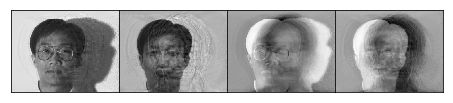

<Figure size 432x288 with 0 Axes>

In [34]:
import random
import matplotlib.gridspec as gridspec

k = np.array(([165]))

r1 = 0
r2 = 0
while r1==r2:
    r1 = random.randint(0, len(dataset)-1)
    r2 = random.randint(0, len(dataset)-1)

sample1 = dataset[r1]
sample2 = dataset[r2]

def project(org_dim_input, eigen_faces):
    return np.dot(org_dim_input, eigen_faces.T)

def reconstruct(projected_input, eigen_faces):
    reconstructed_input = []
    reconstructed_input = np.dot(projected_input, eigen_faces)
    mean_vector = np.mean(org_dataset, axis=0)
    return reconstructed_input + mean_vector

outputs = []
outputs_2=[]
for j in k:
    projected_input1 = project(sample1, eigen_faces[:j])
    reconstructed_input1 = reconstruct(projected_input1, eigen_faces[:j])
    outputs.append(reconstructed_input1)


    projected_input2 = project(sample2, eigen_faces[:j])
    reconstructed_input2 = reconstruct(projected_input2, eigen_faces[:j])
    outputs.append(reconstructed_input2)

    projected_input3=(-0.95)* projected_input1 
    #projected_input3= projected_input1[::-1]
    reconstructed_input3 = reconstruct(projected_input3, eigen_faces[:j])
    outputs.append(reconstructed_input3)
    
    projected_input4=(-0.95)* projected_input2 
    #projected_input4= -1*projected_input2[::-1]
    reconstructed_input4 = reconstruct(projected_input4, eigen_faces[:j])
    outputs.append(reconstructed_input4)

gs = gridspec.GridSpec(len(k), 4* len(k), top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   

i = 0
for g in gs:
    ax = plt.subplot(g)
    #plt.ylabel("k: "+str(k[int(i/2)]))
    ax.imshow(outputs[i].reshape(243, 320), cmap = plt.get_cmap("gray"))
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1    

plt.show()
plt.clf()


# Face recognition using k-nearest neighbor

## Splittting training and testing data

In [37]:
train = []
test = []

i = 0
while i!=15:
    r1 = random.randint(0,10)
    r2 = random.randint(0,10)
    if r1!=r2:
        for j in range(11):
            if j==r1 or j==r2:
                test.append(np.concatenate((org_dataset[i*11+j],[i])))
            else:
                train.append(np.concatenate((org_dataset[i*11+j],[i])))
        i += 1

np.random.shuffle(train)
np.random.shuffle(test)
        
train = np.array(train)
test = np.array(test)

trainX = train[:, :train.shape[1]-1]
testX = test[:, :test.shape[1]-1]
trainY = train[:, train.shape[1]-1]
testY = test[:, test.shape[1]-1]

## K-Nearest Neighbor for Classification

In [39]:
import sklearn
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor

projected_trainX_2 = project(trainX, eigen_faces[:30])       ### dna
projected_testX_2 = project(testX, eigen_faces[:30])


trainX_norm_2 = sklearn.preprocessing.normalize(projected_trainX_2)
testX_norm_2 = sklearn.preprocessing.normalize(projected_testX_2)


lat_long_est = KNeighborsRegressor(n_neighbors=1)
lat_long_est.fit(trainX_norm_2,trainY)
y_predict=lat_long_est.predict(testX_norm_2)

c = 0
for j in range(0, len(testY)):
	if testY[j]==y_predict[j]:
		c += 1

accuracy = c/len(testY)
print("Test accuracy:", accuracy)

Test accuracy: 0.8333333333333334


In [203]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testY, y_predict)

array([[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

# Saving Trained Files to Load into Flask App

In [15]:
# Save KNN
from sklearn.externals import joblib
clf_jblb= KNeighborsRegressor(n_neighbors=1)
clf_jblb.fit(trainX_norm_2,trainY)

filename = 'finalized_modelknn.sav'
joblib.dump(clf_jblb, filename)


['finalized_modelknn.sav']

In [206]:
# Save KNN
import pickle
clf= KNeighborsRegressor(n_neighbors=1)
clf.fit(trainX_norm_2,trainY)
with open('model_knn', 'wb') as f:
    pickle.dump(clf, f)

In [223]:
# Save Normalizer
normalizer = preprocessing.Normalizer().fit(projected_trainX_2)
with open('normalize', 'wb') as f:
    pickle.dump(normalizer, f)

In [204]:
# Save Eigen faces
import pickle
with open('eigenfaces_yale.pickle', 'wb') as f:
    pickle.dump(eigen_faces, f)

In [226]:
normalizer = preprocessing.Normalizer().fit(projected_trainX )
trainX_norm = normalizer.transform(projected_trainX)
testX_norm = normalizer.transform(projected_testX)
len(projected_trainX[0])

20

In [16]:
# Save Tranied Fetures (X)
import pickle
with open('trainX_norm.pickle', 'wb') as f:
    pickle.dump(trainX_norm_2, f)

In [17]:
# Save Y corresponsind to trained X
import pickle
with open('trainY.pickle', 'wb') as f:
    pickle.dump(trainY, f)

Reference:
[1] https://github.com/pritishuplavikar/Face-Recognition-on-Yale-Face-Dataset
[2] https://github.com/jeromevonk/flask_face_detection/blob/master/main.py